In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn import datasets
import numpy as np
import scipy.io as scio
import numpy.random as rng
import tensorflow as tf
import matplotlib.pyplot as plt
rng.seed(1)
tf.set_random_seed(1);
import tensorflow as tf
from scipy.stats import mode


In [2]:
#%%  neural network class
class neural_network:
    def __init__(self, layer_sizes, activationFn = tf.nn.tanh, problem = 'classification'):
        self.dataType = tf.float64;
        self.layer_sizes = layer_sizes;
        self.dim_weights = zip(self.layer_sizes[0:-1], self.layer_sizes[1:])
        self.dim_biases = self.layer_sizes[1:]
        self.nweights = np.sum([np.prod(self.dim_weights[i]) for i in range(len(self.dim_weights))]);
        self.nbiases = np.sum(self.dim_biases);
        self.X = tf.placeholder(shape = [None,self.layer_sizes[0]], dtype=self.dataType, name='X');
        self.y = tf.placeholder(shape = [None,self.layer_sizes[-1]], dtype=self.dataType, name ='y');
        self.activationFn = activationFn;
        self.w = tf.Variable(initial_value= tf.truncated_normal(shape = [self.nweights+self.nbiases], stddev = 0.1, dtype=self.dataType), name='w');
        self.x = tf.random_normal(shape = [1, layer_sizes[0]], dtype = self.dataType);
        self.problem = problem;
    def neural_net(self, X):
        w = self.w;
        layer_sizes = self.layer_sizes;
        dim_weights = self.dim_weights;
        dim_biases = self.dim_biases;
        net = tf.cast(X, dtype=self.dataType);
        pt_w = 0;
        pt_b = self.nweights;
        for i in range(len(layer_sizes[1:])):
            pt_w = np.array([0, np.prod(dim_weights[i])]);
            pt_b = np.array([0, dim_biases[i]]);
            W = tf.reshape(w[pt_w[0]:pt_w[1]],  dim_weights[i]  );
            b = w[pt_b[0]:pt_b[1]];
            if i < (len(layer_sizes[1:])-1):
                net = self.activationFn(tf.matmul(net , W) + b);
            else:
                if self.problem == 'classification':
                    if self.layer_sizes[-1]>1:
                        net = tf.nn.softmax(tf.matmul(net , W) + b);
                    else:
                        net = tf.nn.sigmoid(tf.matmul(net , W) + b);
                elif self.problem == 'regression':
                    net = tf.matmul(net , W) + b;
            pt_w = pt_w+np.prod(dim_weights[i]);
            pt_b = pt_b+dim_biases[i];
                    
        out = net;
        return out
    
    ##### pred_label: returns the label prediction #####
    def predict_out(self, X):
        out = self.neural_net(X);
        if self.problem=='classification':
            predict = tf.argmax(out, 1);
        elif self.problem=='regression':
            predict = out;
        return predict
    ##### logprior_prob: returns the log prior probability of the latent z #####
    def logprior_prob(self):
        """the prior = p(w) = N(0, sI)"""
        w = self.w;
        s = 1.;
        logprior =  -tf.cast( 0.5 / s * (tf.reduce_sum(w**2)), dtype=self.dataType) - 0.5 * tf.cast(tf.shape(w)[0],dtype = self.dataType) * np.log(2*np.pi*s);
        return logprior;
    ##### loglik_prob: returns the log likelihood #####
    def loglik_prob(self, X, y):
        """the log likelihood is bernaulli"""
        out = self.neural_net(X);
        # model params
        if self.problem == 'classification':
            loglik = tf.reduce_sum(y * tf.log(out));
        elif self.problem == 'regression':
            loglik = - tf.reduce_sum((y - out)**2);
        return loglik
    
    ##### logjoint_prob: returns the log joint probability (unnormalized posterior) of the latent z #####
    def logjoint_prob(self):
        """ joint probability """
        logjoint = self.loglik_prob(self.X, self.y) + self.logprior_prob();
        return logjoint
    ##### pred_error: returns the prediction error #####
    def pred_error(self, X, y):
        predict = self.predict_out(X)
        if self.problem == 'classification':
            label = tf.argmax(y, 1)
            correct = tf.reduce_sum(tf.cast(tf.equal(predict, label), dtype=self.dataType))/tf.cast(tf.shape(label)[0], dtype = self.dataType);
            per_error = (1.-correct)*100.;
        elif self.problem == 'regression':
            per_error = tf.reduce_sum((y - predict)**2)/tf.reduce_sum(y**2)*100;
        return per_error


Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/t10k-labels-idx1-ubyte.gz
training data points 55000
testing data points 10000
validation data points 5000
image size is 28 x 28


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


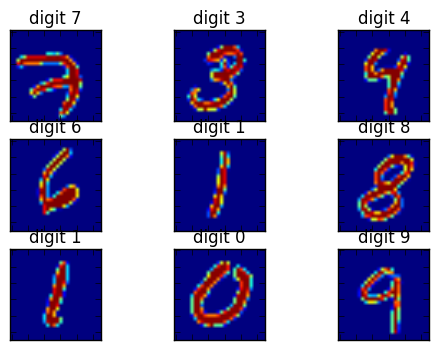

In [3]:
#%% download and store data 
#%% download and store data 
from tensorflow.examples.tutorials import mnist
directory = '/Users/gamalamin/git_local_repository/exploration/'
mnist_data = mnist.input_data.read_data_sets(directory + 'data/MNIST', one_hot=True)
train_data =  mnist_data.train; #{'images': mnist_data.train.images, 'labels': mnist_data.train.labels};
test_data =  mnist_data.test; #{'images': mnist_data.test.images, 'labels': mnist_data.test.labels};
validation_data =  mnist_data.validation; #{'images': mnist_data.validation.images, 'labels': mnist_data.validation.labels};
num_classes = 10;

l = np.sqrt(train_data.images.shape[1]);
digits = np.array(range(num_classes)); # possible digits
"""
data structure:
    mnist_data.train 55,000 training digit images each of size (28 x 28)
    mnist_data.test 10,000 testing images    
    mnist_data.validation 5,000 testing images
"""

print "training data points %d"  %train_data.images.shape[0];
print "testing data points %d"  %test_data.images.shape[0];
print "validation data points %d"  %validation_data.images.shape[0];
print "image size is %d x %d"  %(l, l);

_, axarr= plt.subplots(3,3)
for i in range(9):
    axarr[i/3, i%3].imshow(np.reshape(train_data.images[i, :], (l, l)));
    axarr[i/3, i%3].set_title(('digit %d' %digits[train_data.labels[i, :].astype('bool')]))
    axarr[i/3, i%3].set_xticklabels(' ')
    axarr[i/3, i%3].set_yticklabels(' ')
plt.show('all')

In [4]:
z_dim = 100;  # dimensionality of noise
G = neural_network([z_dim, 1200, 1200, int(l**2)], activationFn=tf.nn.tanh)
D = neural_network([int(l**2), 240, 240, 1], activationFn=tf.nn.tanh)
patch_size = 200 
tvars_G = [G.w];
tvars_D = [D.w];
tiny = 1e-100;
X_orig = tf.placeholder(shape=[None, int(l**2)], dtype = G.dataType); # data patch
z = tf.placeholder(shape=[None, z_dim], dtype = G.dataType);   # random noise
cost = tf.reduce_mean(tf.log(D.neural_net(X_orig))+tf.log((1. - D.neural_net(G.neural_net(z)))+tiny))
cost_D = - tf.reduce_mean(tf.log(D.neural_net(X_orig))+tf.log((1. - D.neural_net(G.neural_net(z)))+tiny));
cost_G =  tf.reduce_mean(tf.log((1. - D.neural_net(G.neural_net(z)))+tiny));
grads_D = tf.gradients(cost_D, tvars_D); 
grads_G = tf.gradients(cost_G, tvars_G);  
grads_and_vars_D = zip(grads_D, tvars_D);
grads_and_vars_G = zip(grads_G, tvars_G);

In [5]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

In [6]:
# sess.run(init)
# batch_xs, _ = mnist_data.train.next_batch(patch_size)
# feed_dict = {X_orig:batch_xs, z: rng.randn(patch_size, z_dim)}
# sess.run(D.neural_net(X_orig)>0.5,feed_dict=feed_dict)

In [ ]:
# sess.run(init)
batch_xs, _ = mnist_data.train.next_batch(patch_size)
feed_dict = {X_orig:batch_xs, z: rng.randn(patch_size, z_dim)}
grads_G[0].eval(feed_dict=feed_dict).sum()

In [ ]:
G.neural_net(z).eval(feed_dict=feed_dict)

In [7]:
learning_rate = 0.2;
optimizer_G = tf.train.AdamOptimizer(learning_rate=0.002)
optimizer_D = tf.train.AdamOptimizer(learning_rate=0.002)
train_step_G = optimizer_G.apply_gradients(grads_and_vars_G)
train_step_D = optimizer_D.apply_gradients(grads_and_vars_D)
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [ ]:
# sess.run(init)
maxiter =1000;
ELBO_list = [];
test_error = [];
cost_G_list = [];
cost_D_list = [];
for i in range(maxiter):
    batch_xs, _ = mnist_data.train.next_batch(patch_size)
    feed_dict = {X_orig:batch_xs, z: rng.randn(patch_size, z_dim)}
    for k in range(1):
        1.
        sess.run(train_step_D, feed_dict=feed_dict)
    feed_dict = {X_orig:batch_xs, z: rng.randn(patch_size, z_dim)}
    sess.run(train_step_G, feed_dict=feed_dict)
    cost_i= sess.run((cost_D, cost_G), feed_dict=feed_dict)
    cost_D_list +=[cost_i[0]];
    cost_G_list += [cost_i[1]];
#     print ("iter %d, generator cost = %.20f, disciminator cost = %.20f" %(i, cost_G_list[i], cost_D_list[i]))

In [ ]:
feed_dict = {X_orig:batch_xs, z: rng.randn(patch_size, z_dim)}
sess.run(D.neural_net(G.neural_net(z))>0.5, feed_dict=feed_dict)
sess.run(D.neural_net(X_orig)>0.5, feed_dict=feed_dict)

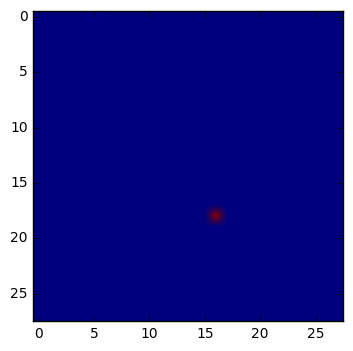

In [11]:
feed_dict = {z: rng.randn(patch_size, z_dim)}
plt.imshow(np.reshape(G.neural_net(z).eval(feed_dict=feed_dict)[0,:], (l,l)));
plt.show()